<a href="https://colab.research.google.com/github/yxbxn/python/blob/main/%5BPytorch%5D_%EB%A7%A4%EC%9A%B0_%EA%B0%84%EB%8B%A8%ED%95%9C_1D_AutoEncoder_%ED%99%9C%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score

In [12]:
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')
import matplotlib

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## 하이퍼파라미터

In [3]:
EPOCHS = 400
LR = 1e-2
BS = 16384
SEED = 41

## 시드고정

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED) # Seed 고정

## 데이터로드

In [5]:
# 구글드라이브 연동
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [8]:
# 특정 파일 불러오기
import pandas as pd
train_df = pd.read_csv("/content/MyDrive/MyDrive/dacon/train.csv")
train_df = train_df.drop(columns=['ID'],axis=1)

val_df = pd.read_csv("/content/MyDrive/MyDrive/dacon/val.csv")
val_df = val_df.drop(columns=['ID'],axis=1)

test_df = pd.read_csv("/content/MyDrive/MyDrive/dacon/test.csv")
test_df = test_df.drop(columns=['ID'],axis=1)

## 데이터셋 정리

In [111]:
data = pd.concat([train_df,val_df.drop("Class",axis=1),test_df],ignore_index = True)

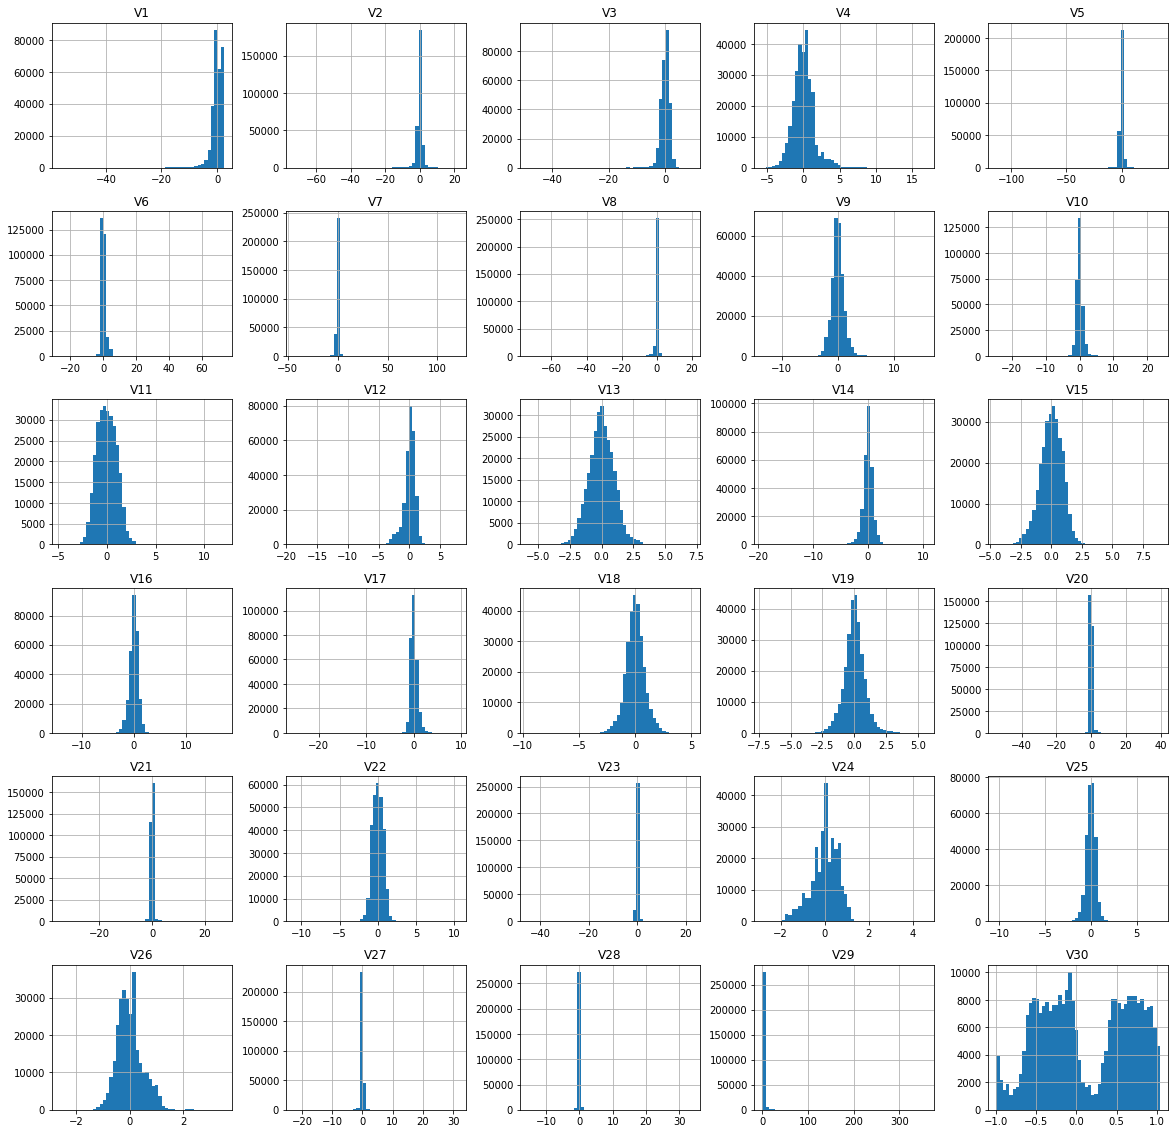

In [112]:
data.hist(bins = 50, figsize = (20,20))
plt.show()

In [113]:
loglist=[]
# 왜도 3인 설명변수 log1p 변환
for val in data.columns:
    if abs(data[val].skew())>3:
        loglist.append(val)
        print(val," 왜도 skew 값: ",data[val].skew())
        print("log 변환 처리 이후 skew 값 ",abs(np.log1p(data[val])).skew())
        print("----------------------------------------")
loglist

V1  왜도 skew 값:  -3.28066730275604
log 변환 처리 이후 skew 값  2.973916767990412
----------------------------------------
V2  왜도 skew 값:  -4.624865573285338
log 변환 처리 이후 skew 값  3.062745593187156
----------------------------------------
V8  왜도 skew 값:  -8.521944194777976
log 변환 처리 이후 skew 값  3.939580011946287
----------------------------------------
V17  왜도 skew 값:  -3.8449144738706216
log 변환 처리 이후 skew 값  3.0223215702424278
----------------------------------------
V21  왜도 skew 값:  3.5929911930778453
log 변환 처리 이후 skew 값  5.024034406941592
----------------------------------------
V23  왜도 skew 값:  -5.875140340106816
log 변환 처리 이후 skew 값  5.156909009680588
----------------------------------------
V28  왜도 skew 값:  11.192091192212805
log 변환 처리 이후 skew 값  7.720284165605865
----------------------------------------
V29  왜도 skew 값:  16.97772445376101
log 변환 처리 이후 skew 값  2.377080298739156
----------------------------------------


['V1', 'V2', 'V8', 'V17', 'V21', 'V23', 'V28', 'V29']

log 변환 적용하기

In [114]:
data.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30'],
      dtype='object')

In [115]:
for col in data.columns:
    print(data[col].min())

-56.407509631329
-72.7157275629303
-48.3255893623954
-5.68317119816995
-113.743306711146
-26.1605059358433
-43.5572415712451
-73.2167184552674
-13.4340663182301
-24.5882624372475
-4.79747346479757
-18.6837146333443
-5.79188120632084
-19.2143254902614
-4.49894467676621
-14.1298545174931
-25.1627993693248
-9.49874592104677
-7.21352743017759
-54.497720494566
-34.8303821448146
-10.933143697655
-44.8077352037913
-2.83662691870341
-10.2953970749851
-2.60455055280817
-22.5656793207827
-15.4300839055349
-0.3074128414727869
-0.9949834936970594


In [116]:
for val in loglist:
    if data[val].min() < 0:
        data[val] += data[val].min()*(-1)

    data[val+"_scale"] = np.log1p(data[val])
    data.drop([val],axis=1,inplace=True)
    print(val)

V1
V2
V8
V17
V21
V23
V28
V29


In [117]:
data.head()

,V3,V4,V5,V6,V7,V9,V10,V11,V12,V13,...,V27,V30,V1_scale,V2_scale,V8_scale,V17_scale,V21_scale,V23_scale,V28_scale,V29_scale
0,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,0.717293,...,-0.055353,-0.994972,4.026229,4.281869,4.310321,3.305889,3.585694,3.844111,2.795471,1.839141
1,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,0.507757,...,0.062723,-0.994972,4.033200,4.297700,4.312062,3.237843,3.575769,3.820290,2.802848,1.002727
2,1.141109,-0.168252,0.420987,-0.029728,0.476201,-0.568671,-0.371407,1.341262,0.359894,-0.358091,...,0.253844,-0.994960,4.042727,4.313162,4.310491,3.262114,3.572967,3.823877,2.804037,0.050010
3,1.074380,-0.492199,0.948934,0.428118,1.120631,0.615375,1.249376,-0.619468,0.291474,1.757964,...,-1.206921,-0.994901,4.038889,4.319269,4.254319,3.216500,3.631617,3.825708,2.730773,0.451146
4,-0.113192,-0.271526,2.669599,3.721818,0.370145,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,...,0.011747,-0.994901,4.034475,4.304091,4.318392,3.245051,3.576745,3.819985,2.807744,0.833914


In [119]:
train_col = data.columns
train_col

Index(['V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V18', 'V19', 'V20', 'V22', 'V24', 'V25', 'V26', 'V27',
       'V30', 'V1_scale', 'V2_scale', 'V8_scale', 'V17_scale', 'V21_scale',
       'V23_scale', 'V28_scale', 'V29_scale'],
      dtype='object')

In [81]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [82]:
for col in data.columns:
    
    scaler = StandardScaler()
    
    scale_data = scaler.fit_transform(data[col].values.reshape(-1,1))
    data[col] = scale_data

In [83]:
data.head()

,V3,V4,V5,V6,V7,V9,V10,V11,V12,V13,...,V27,V30,V1_scale,V2_scale,V8_scale,V17_scale,V21_scale,V23_scale,V28_scale,V29_scale
0,1.169468,0.268231,-0.364572,1.351454,0.639776,-1.378675,0.190700,0.611830,0.066137,0.720700,...,-0.137137,-1.996562,-0.618008,-0.705900,0.180885,1.080737,0.332098,1.211150,-0.170573,2.169235
1,1.182516,-0.609727,-0.007469,0.936150,0.192071,-1.262503,-0.050468,-0.221892,0.178371,0.510169,...,0.155396,-1.996562,-0.433061,-0.087107,0.271214,-0.662082,-0.131337,-0.248325,0.194505,0.803895
2,0.752585,-0.118833,0.305009,-0.022313,0.384936,-0.517619,-0.341101,1.314046,0.360182,-0.359792,...,0.628900,-1.996541,-0.180289,0.517232,0.189690,-0.040440,-0.262175,-0.028563,0.253355,-0.751293
3,0.708576,-0.347631,0.687512,0.321345,0.905860,0.560129,1.147430,-0.606898,0.291708,1.766314,...,-2.990154,-1.996436,-0.282129,0.755929,-2.724601,-1.208734,2.476470,0.083614,-3.372394,-0.096490
4,-0.074653,-0.191774,1.934149,2.793594,0.299206,-0.356851,-0.376940,-0.690809,-0.110541,-0.287613,...,0.029104,-1.996436,-0.399244,0.162662,0.599605,-0.477456,-0.085771,-0.267013,0.436821,0.528330


## 데이터셋 생성

In [84]:
class MyDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        if self.eval_mode:
            self.labels = self.df['Class'].values
            self.df = self.df.drop(columns=['Class']).values
        else:
            self.df = self.df.values
        
    def __getitem__(self, index):
        if self.eval_mode:
            self.x = self.df[index]
            self.y = self.labels[index]
            return torch.Tensor(self.x), self.y
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x)
        
    def __len__(self):
        return len(self.df)

In [85]:
train_dataset = MyDataset(df=train_df, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=6)

val_dataset = MyDataset(df = val_df, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=6)

## 1D AutoEncoder

In [86]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(30,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )
        self.Decoder = nn.Sequential(
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64,30),
        )
        
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

## Train (학습)

In [87]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.L1Loss().to(self.device)
        
    def fit(self, ):
        self.model.to(self.device)
        best_score = 0
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()

                _x = self.model(x)
                loss = self.criterion(x, _x)

                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

            score = self.validation(self.model, 0.95)
            print(f'Epoch : [{epoch}] Train loss : [{np.mean(train_loss)}] Val Score : [{score}])')

            if self.scheduler is not None:
                self.scheduler.step(score)

            if best_score < score:
                best_score = score
                torch.save(model.module.state_dict(), './best_model.pth', _use_new_zipfile_serialization=False)
    
    def validation(self, eval_model, thr):
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        eval_model.eval()
        pred = []
        true = []
        with torch.no_grad():
            for x, y in iter(self.val_loader):
                x = x.float().to(self.device)

                _x = self.model(x)
                diff = cos(x, _x).cpu().tolist()
                batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
                pred += batch_pred
                true += y.tolist()

        return f1_score(true, pred, average='macro')

## 모델 학습

In [88]:
model = nn.DataParallel(AutoEncoder())
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5370450190135411] Val Score : [0.0025295113983675546])
Epoch : [1] Train loss : [0.353203011410577] Val Score : [0.11469736766126254])
Epoch : [2] Train loss : [0.2670533231326512] Val Score : [0.30696384850452524])
Epoch : [3] Train loss : [0.2174352662903922] Val Score : [0.3769625130322644])
Epoch : [4] Train loss : [0.18637913465499878] Val Score : [0.44575724386350246])
Epoch : [5] Train loss : [0.16547850412981852] Val Score : [0.4716149901712482])
Epoch : [6] Train loss : [0.1505056279046195] Val Score : [0.4853230261800434])
Epoch : [7] Train loss : [0.14029540973050253] Val Score : [0.49219101905022994])
Epoch : [8] Train loss : [0.1320484642471586] Val Score : [0.4971218579894749])
Epoch : [9] Train loss : [0.12731147131749562] Val Score : [0.500237456548652])
Epoch : [10] Train loss : [0.12142255795853478] Val Score : [0.5019615756952024])
Epoch : [11] Train loss : [0.11733524394886834] Val Score : [0.5039959969348181])
Epoch : [12] Train loss : [

## 추론

In [89]:
model = AutoEncoder()
model.load_state_dict(torch.load('./best_model.pth'))
model = nn.DataParallel(model)
model.eval()

DataParallel(
  (module): AutoEncoder(
    (Encoder): Sequential(
      (0): Linear(in_features=30, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=64, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
    (Decoder): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=64, out_features=30, bias=True)
    )
  )
)

In [136]:
test_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,0.309755,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142498,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,-0.111640,...,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,0.028645,1.034904
142499,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,-0.594242,...,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,0.810312,1.034916
142500,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0.038986,1.034963
142501,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.641096,1.034975


In [137]:
loglist=[]
data = test_df.copy()

# 왜도 3인 설명변수 log1p 변환
for val in data.columns:
    if abs(data[val].skew())>3:
        loglist.append(val)
        print(val," 왜도 skew 값: ",data[val].skew())
        print("log 변환 처리 이후 skew 값 ",abs(np.log1p(data[val])).skew())
        print("----------------------------------------")

for val in loglist:
    if data[val].min() < 0:
        data[val] += data[val].min()*(-1)

    data[val+"_scale"] = np.log1p(data[val])
    data.drop([val],axis=1,inplace=True)
    print(val)

V1  왜도 skew 값:  -3.2676261088792384
log 변환 처리 이후 skew 값  2.973783369240745
----------------------------------------
V2  왜도 skew 값:  -4.4506683090186145
log 변환 처리 이후 skew 값  3.061544178759392
----------------------------------------
V5  왜도 skew 값:  -4.1131559579571295
log 변환 처리 이후 skew 값  2.8657201648418713
----------------------------------------
V7  왜도 skew 값:  4.4840832613390935
log 변환 처리 이후 skew 값  3.2305576678643737
----------------------------------------
V8  왜도 skew 값:  -9.133349565873987
log 변환 처리 이후 skew 값  3.8446059972147295
----------------------------------------
V17  왜도 skew 값:  -4.979123326267669
log 변환 처리 이후 skew 값  3.0306617084645944
----------------------------------------
V21  왜도 skew 값:  3.277702965514593
log 변환 처리 이후 skew 값  5.058693619853066
----------------------------------------
V23  왜도 skew 값:  -5.262646146357439
log 변환 처리 이후 skew 값  5.088820489089459
----------------------------------------
V29  왜도 skew 값:  21.225197781025056
log 변환 처리 이후 skew 값  2.375725527205

In [138]:
data.columns

Index(['V3', 'V4', 'V6', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16',
       'V18', 'V19', 'V20', 'V22', 'V24', 'V25', 'V26', 'V27', 'V28', 'V30',
       'V1_scale', 'V2_scale', 'V5_scale', 'V7_scale', 'V8_scale', 'V17_scale',
       'V21_scale', 'V23_scale', 'V29_scale'],
      dtype='object')

In [139]:
for col in data.columns:
    
    scaler = StandardScaler()
    
    scale_data = scaler.fit_transform(data[col].values.reshape(-1,1))
    data[col] = scale_data

In [164]:
test_data = data.copy()

컬럼 순서 변경해보기

In [154]:
len(test_data.columns)

33

In [155]:
len(train_col)

30

In [156]:
train_col

Index(['V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V18', 'V19', 'V20', 'V22', 'V24', 'V25', 'V26', 'V27',
       'V30', 'V1_scale', 'V2_scale', 'V8_scale', 'V17_scale', 'V21_scale',
       'V23_scale', 'V28_scale', 'V29_scale'],
      dtype='object')

In [165]:
test_data = test_data[['V3', 'V4','V6','V9', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V18', 'V19', 'V20', 'V22', 'V24', 'V25', 'V26', 'V27','V28',
       'V30','V1_scale', 'V2_scale','V5_scale','V7_scale','V8_scale',
       'V17_scale', 'V21_scale', 'V23_scale','V29_scale']]

In [167]:
test_dataset = MyDataset(test_data, False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=6)

In [168]:
def prediction(model, thr, test_loader, device):
    model.to(device)
    model.eval()
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    pred = []
    with torch.no_grad():
        for x in iter(test_loader):
            x = x.float().to(device)
            
            _x = model(x)
            
            diff = cos(x, _x).cpu().tolist()
            batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
            pred += batch_pred
    return pred

In [169]:
preds = prediction(model, 0.95, test_loader, device)

In [170]:
submit = pd.read_csv('/content/MyDrive/MyDrive/dacon/sample_submission.csv')
submit['Class'] = preds
submit.to_csv('/content/MyDrive/MyDrive/dacon/submit_autoencoder_thr_0.95.csv', index=False)